Combustion Engines identification using Machine Learning techniques

USP Esalq - MBA Data Science & Analytics - 2022/2

Matheus Felipe Sozza

# 1. Libraries Installing and Importing

## 1.1. Install and Import libraries

In [ ]:
#pip install librosa numpy pandas matplotlib scipy sklearn IPython mir_eval dill

In [1]:
# Import modules
%matplotlib inline
import dill
import sys
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import librosa
import librosa.display
import pandas as pd
import os
import scipy.signal
import math
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Custom library created for the project
import soundDetection_AuxiliarFunctions

## 1.2. Import **Audio** files and **Metadata** from file system

In [29]:
# Path related variables
PROJECT_PATH = 'C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/'
METADATA_FILE = PROJECT_PATH + 'DatasetMapping.csv'
AUDIOS_PATH = PROJECT_PATH + 'UrbanSounds8k'

# Audio segmentation variables
AUDIOSEG_SIZE = 10 # windows or ~464.4ms
AUDIOSEG_OVERLAP = 0.5 # normalized

# 2. **Audios Dataset** creation (Pandas)

In [3]:
from soundDetection_AuxiliarFunctions import createAudiosDataset
audios_DF = soundDetection_AuxiliarFunctions.createAudiosDataset(METADATA_FILE, AUDIOS_PATH)

C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/100032-3-0-0.wav  ---> Index:  0
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/122690-6-0-0.wav  ---> Index:  1000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/147926-0-0-44.wav  ---> Index:  2000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/162434-6-2-0.wav  ---> Index:  3000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/178260-7-1-9.wav  ---> Index:  4000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/195969-0-0-19.wav  ---> Index:  5000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/30204-0-0-11.wav  ---> Index:  6000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/60605-9-0-90.wav  ---> Index:  7000
C:/Users/SZM1JVL/Documents/PESSOAL - MBA DSA TCC/UrbanSounds8k/77751-4-9-1.wav  ---> Index:  8000
Number of processed audio files: 8732


In [10]:
#  Label if it is an engine sound
audios_DF['isEngine'] = audios_DF['class'].map({'engine_idling': 1, 'air_conditioner':0, 'car_horn':0,
                                       'children_playing':0, 'dog_bark':0, 'drilling':0, 'gun_shot':0,
                                       'jackhammer':0, 'siren':0, 'street_music':0}, na_action=None)

audios_DF.head()

,filename,duration,class,isEngine
0,100032-3-0-0.wav,0.317551,dog_bark,0
1,100263-2-0-117.wav,4.000000,children_playing,0
2,100263-2-0-121.wav,4.000000,children_playing,0
3,100263-2-0-126.wav,4.000000,children_playing,0
4,100263-2-0-137.wav,4.000000,children_playing,0


In [9]:
# Audios histogram per type
#audios_DF['isEngine'].plot.hist(bins=12, alpha=0.5)

In [14]:
# Audios histogram per duration
#audios_DF['duration'].plot.hist(bins=12, alpha=0.5,)
#audios_DF.plot.hist(column=["duration"],by="class", bins=4, alpha=1, figsize=(10, 25),)

# 3. Process the sound files and extract spectogram

## 3.1. Process and get spectogram

Text(0, 0.5, 'Signal')

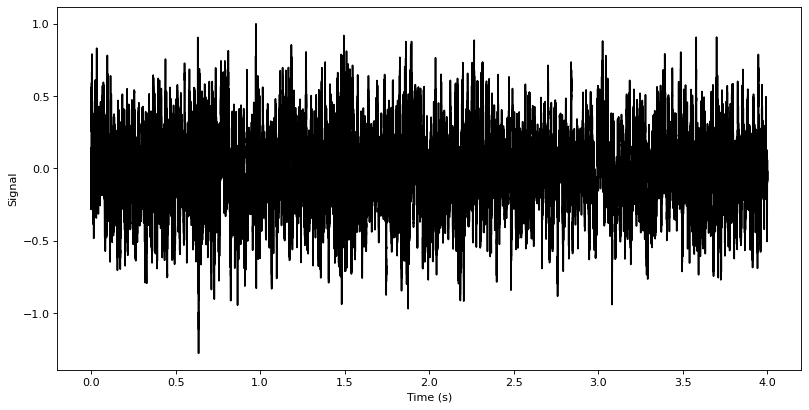

In [6]:
audioMatrix, spectMatrix = soundDetection_AuxiliarFunctions.extractSpectogram(AUDIOS_PATH + '/100263-2-0-161.wav')

# Plot Audio signal
figure(figsize=(12,6), dpi=80)
plt.plot(audioMatrix['time'], audioMatrix['data'], color='black')
plt.xlabel('Time (s)')
plt.ylabel('Signal')

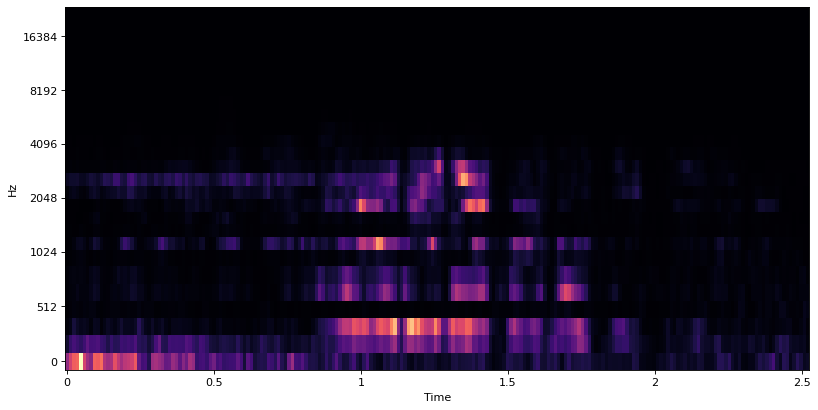

In [11]:
# Plot Mel Spectogram
figure(figsize=(12,6), dpi=80)
img = librosa.display.specshow(spectMatrix, x_axis='time',y_axis='mel', sr=44100)

In [8]:
# Compile all audios in an array of Spectogram Matrices
spectogram_AM = []

# Append all the spectograms matrices in a single array
for idx, rowData in audios_DF.iterrows():
    if(idx%1000 == 0):
        print(idx)

    audioMatrix, spectMatrix = soundDetection_AuxiliarFunctions.extractSpectogram(AUDIOS_PATH + '/' + rowData['filename'])
    spectogram_AM.append(spectMatrix)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500


## 3.2. Create segmented subset

In [57]:
audios_DF['subSegs'] = np.zeros(audios_DF.shape[0]) # Create new column for sub segementation

8732

In [61]:
audios_DF['subSegs'][0] = 1

C:\Users\SZM1JVL\AppData\Local\Temp\ipykernel_8692\1803028581.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  audios_DF['subSegs'][0] = 1


In [64]:
audios_DF['subSegs'] = np.zeros(audios_DF.shape[0]) # Create new column for sub segementation
subSpectogram_AM = []

# Prepare the loop through all spectograms
idxSpect = 0
idxSubSpect = 0
for spectogram in spectogram_AM:
    # Get spectogram length / duration & add it to dataset
    spectSize = (spectogram_AM[idxSpect].shape)[1]
    audios_DF['subSegs'][idxSpect] = spectSize
    
    # Check if satisfies size of at least a single window
    if spectSize >= (1+ (1-AUDIOSEG_OVERLAP)) * AUDIOSEG_SIZE:
        # Create segments
        numSubSegs = np.floor((spectSize - AUDIOSEG_SIZE)/(AUDIOSEG_SIZE*(1-AUDIOSEG_OVERLAP))) +1
        
        print('---')
        print('spectSize' , spectSize)
        print('numSubSegs', numSubSegs)

        for idxSubSpect in np.arange(numSubSegs):
            #print('subSpect', idxSubSpect)



    idxSpect = idxSpect+1

IndentationError: expected an indented block after 'for' statement on line 21 (1085361570.py, line 26)

# STOPPED HEREE